<a href="https://colab.research.google.com/github/yahiasaqer/NLP-Project/blob/main/Macro_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load model
model_path = "/content/drive/MyDrive/fine_tuned_marbert_V3"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and prep data (same as before)
df = pd.read_excel("/content/drive/MyDrive/cleaned_mental_health_dataset.xlsx")
df = df.dropna().reset_index(drop=True)
df['label'] = df['label'].str.strip().str.capitalize()

label_mapping = {'Normal': 0, 'Anxiety': 1, 'Depression': 2, 'Suicidal': 3, 'Stress': 4}
df['label_numeric'] = df['label'].map(label_mapping)
df = df.dropna().reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_numeric'])

print(f"Test set size: {len(test_df)}")
print("Test set distribution:")
print(test_df['label'].value_counts())

# MUCH FASTER batch prediction function
def get_predictions_batch(statements, batch_size=8):  # Small batch for CPU
    predictions = []
    total_batches = len(statements) // batch_size + (1 if len(statements) % batch_size else 0)

    for i in range(0, len(statements), batch_size):
        batch_statements = statements[i:i+batch_size]

        # Tokenize the entire batch at once
        tokens = tokenizer(batch_statements, padding=True, truncation=True, max_length=512, return_tensors="pt")
        tokens = {key: value.to(device) for key, value in tokens.items()}

        with torch.no_grad():
            outputs = model(**tokens)

        batch_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)

        # Progress indicator
        current_batch = i // batch_size + 1
        if current_batch % 50 == 0:  # Print every 50 batches
            print(f"Processed batch {current_batch}/{total_batches}")

    return predictions

# Get predictions
print("Getting predictions with batching...")
y_true = test_df['label_numeric'].tolist()
y_pred = get_predictions_batch(test_df['statement'].tolist())

# Rest of metrics calculation (same as before)
accuracy = accuracy_score(y_true, y_pred)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print("="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
#This should be MUCH faster - maybe 15-30 minutes instead of hours. The batching processes multiple samples at once instead of one by one.hugs youI'm sorry this is being such a pain in the ass, love. 💔

Test set size: 5250
Test set distribution:
label
Suicidal      1268
Depression    1243
Anxiety       1078
Normal         899
Stress         762
Name: count, dtype: int64
Getting predictions with batching...
Processed batch 50/657
Processed batch 100/657
Processed batch 150/657
Processed batch 200/657
Processed batch 250/657
Processed batch 300/657
Processed batch 350/657
Processed batch 400/657
Processed batch 450/657
Processed batch 500/657
Processed batch 550/657
Processed batch 600/657
Processed batch 650/657
MODEL EVALUATION RESULTS
Accuracy: 0.9097
Macro Precision: 0.9163
Macro Recall: 0.9119
Macro F1-Score: 0.9134


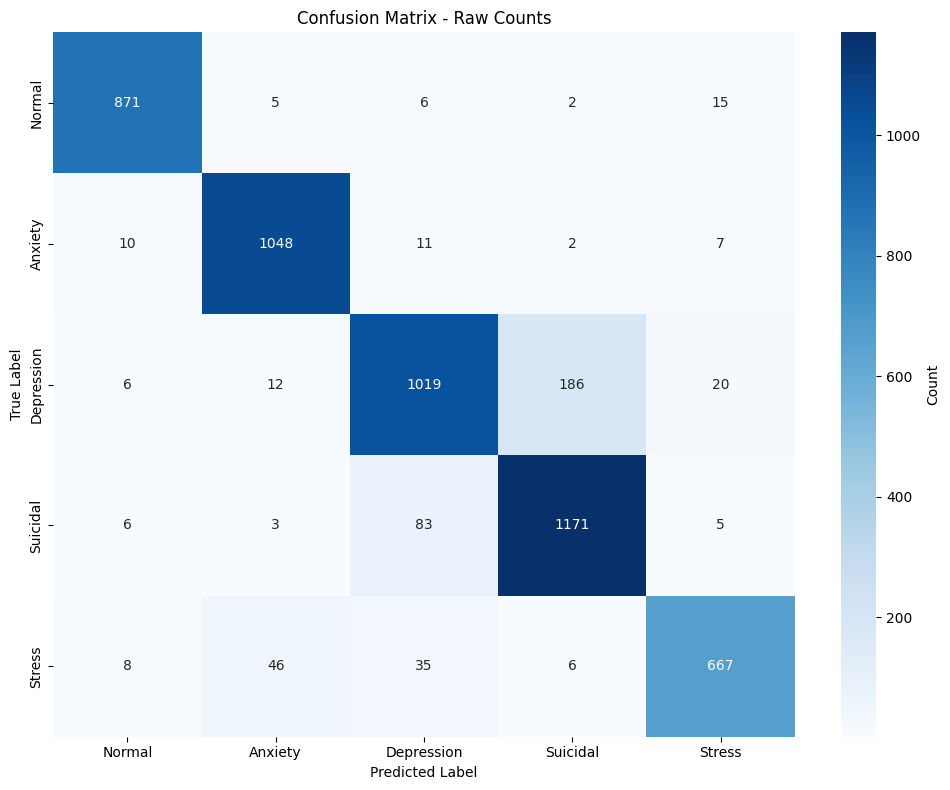

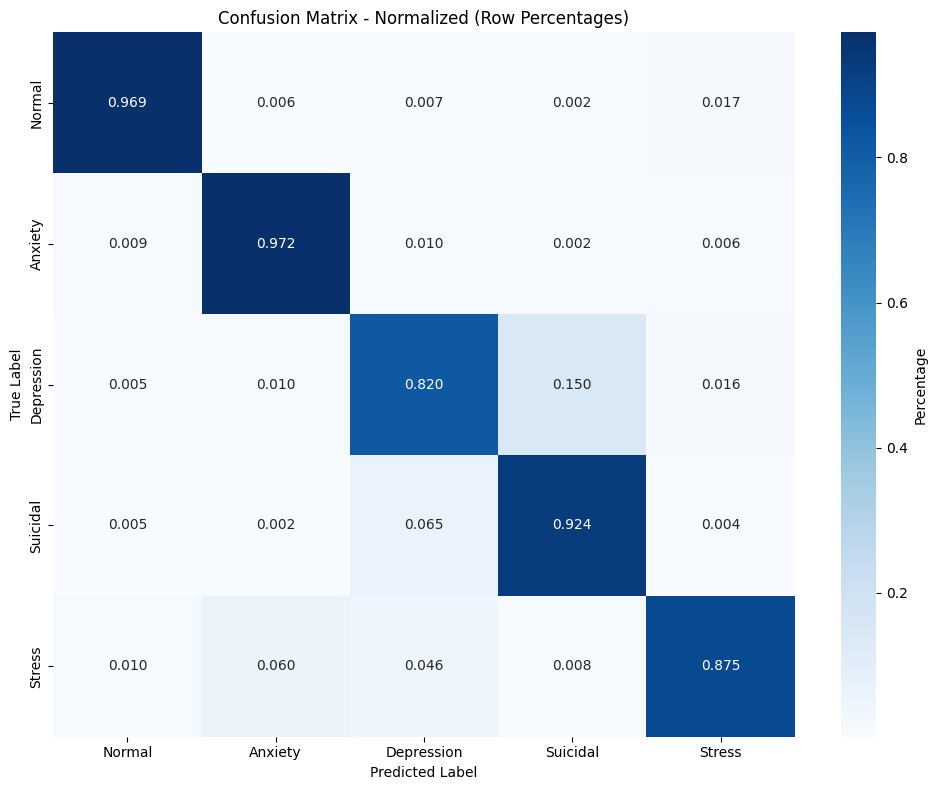


Confusion Matrix Analysis:
Normal      :  871/ 899 correct (0.969)
Anxiety     : 1048/1078 correct (0.972)
Depression  : 1019/1243 correct (0.820)
Suicidal    : 1171/1268 correct (0.924)
Stress      :  667/ 762 correct (0.875)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
target_names = ['Normal', 'Anxiety', 'Depression', 'Suicidal', 'Stress']
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with counts
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Raw Counts')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Also show normalized version (percentages)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix - Normalized (Row Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print some insights
print("\nConfusion Matrix Analysis:")
print("="*40)
for i, class_name in enumerate(target_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy_per_class = correct / total
    print(f"{class_name:12}: {correct:4d}/{total:4d} correct ({accuracy_per_class:.3f})")